<a href="https://colab.research.google.com/github/aswanath-p/DL/blob/master/email_phishing1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import model_selection, naive_bayes, svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split, cross_val_predict, learning_curve
from sklearn.metrics import r2_score, accuracy_score
import numpy as np

In [ ]:
test = pd.read_csv('/content/Real_time_emails - label Project.csv')
test.sample(5)

,From,To,Reply-to,Subject,Attachments,Email Text,phishing,@ in URLs,Css,Encoding,External Resources,Flash content,HTML content,Html Form,Html iFrame,IPs in URLs,Javascript,Phishy,URLs,Class_of_mail
2880,26.mohit@gmail.com,"shivarajesh9871@gmail.com, vishnupriya8909@gma...",NaN,Re: Google meeting at 5:30 PM,NaN,Subject: nominations for eastrans reciept for ...,ham,NaN,0,7bit,0,False,NaN,False,False,False,0,NaN,NaN,NaN
1971,info@naukri.com,aswanath.p@gmail.com,NaN,Check Out Top Companies Hiring Now!,NaN,Subject: new book\nplease create the following...,ham,NaN,0,7bit,0,False,NaN,False,False,False,0,NaN,NaN,NaN
2026,info@interviewbit.com,aswanath.p@gmail.com,NaN,Everyone who gets into Google can solve this p...,NaN,Subject: mobil beaumont - marol\njust want to ...,ham,NaN,0,7bit,0,False,NaN,False,False,False,0,NaN,NaN,NaN
559,newsletter@gmatclub.com,aswanath.p@gmail.com,NaN,3 Months to a 700+ GMAT,NaN,Subject: 108 mbps wireless firewall 4 - port r...,spam,NaN,0,7bit,0,False,NaN,False,False,False,0,NaN,NaN,NaN
2961,info@naukri.com,aswanath.p@gmail.com,NaN,Check Out Top Companies Hiring Now!,NaN,"Subject: re : base gas roll\nthanks ,\ngg\nfro...",ham,NaN,0,none,0,False,NaN,False,False,False,0,NaN,NaN,NaN


In [ ]:
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
import re
def preprocess(string):
  processed_string = re.sub('[^a-z0-9]+', ' ', string, flags=re.IGNORECASE)
  processed_string = re.sub('(\s+)', ' ', processed_string)
  processed_string = processed_string.lower()
  return [ele for ele in processed_string.split() if not ele in list(stop_words) + ['subject']]

In [ ]:
def cleaning(text):

    import string
    exclude = set(string.punctuation)

    import re
    # remove new line and digits with regular expression
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\d', '', text)
    # remove patterns matching url format
    url_pattern = r'((http|ftp|https):\/\/)?[\w\-_]+(\.[\w\-_]+)+([\w\-\.,@?^=%&amp;:/~\+#]*[\w\-\@?^=%&amp;/~\+#])?'
    text = re.sub(url_pattern, ' ', text)
    # remove non-ascii characters
    text = ''.join(character for character in text if ord(character) < 128)
    # remove punctuations
    text = ''.join(character for character in text if character not in exclude)
    # standardize white space
    text = re.sub(r'\s+', ' ', text)
    # drop capitalization
    text = text.lower()
    #remove white space
    text = text.strip()

    return text

In [ ]:
test['Email Text'][700]

'Subject: second revision to my spreadsheet - changes to previous one are\nnoted as rev 2\nrevisions to devon # \' s .\nbeverly\n- - - - - - - - - - - - - - - - - - - - - - forwarded by beverly beaty / hou / ect on 11 / 29 / 2000 09 : 57\nam - - - - - - - - - - - - - - - - - - - - - - - - - - -\nenron capital & trade resources corp .\nfrom : " victor haley "\n11 / 29 / 2000 10 : 54 am\nto :\ncc :\nsubject : second revision to my spreadsheet - changes to previous one are noted\nas rev 2\nsecond revision to my spreadsheet - changes to previous one are noted as rev\n2\n- enronavailsl 200 pools . xls'

In [ ]:
print(cleaning(test['Email Text'][700]))

subject second revision to my spreadsheet changes to previous one arenoted as rev revisions to devon s beverly forwarded by beverly beaty hou ect on am enron capital trade resources corp from victor haley amto cc subject second revision to my spreadsheet changes to previous one are notedas rev second revision to my spreadsheet changes to previous one are noted as rev enronavailsl pools xls


In [ ]:
test['phishing'].value_counts()

ham     1651
spam     590
Name: phishing, dtype: int64

In [ ]:
X = test['Email Text'].values
y = test['phishing'].values

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

y = le.fit_transform(y)
X = list(X)
y = list(y)
print(set(y))
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.05, random_state = 42)
print(len(train_X), len(test_X))

{0, 1}
2128 113


In [ ]:
training_sentences = [cleaning(ele) for ele in train_X]
testing_sentences = [cleaning(ele) for ele in test_X]

In [ ]:
train_1 = [preprocess(ele) for ele in training_sentences]
test_1 = [preprocess(ele) for ele in testing_sentences]

In [ ]:
vocab_size = 10000
embedding_dim = 10
max_length = 100

oov_tok = '<OOV>'
trunc_type = 'post'

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 10)           100000    
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 6006      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 106,013
Trainable params: 106,013
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import numpy as np
num_epochs = 5
model.fit(padded, np.array(train_y), epochs = num_epochs, validation_data = (testing_padded, np.array(test_y)))

Epoch 1/5
67/67 [==============================] - 2s 15ms/step - loss: 0.6343 - accuracy: 0.7261 - val_loss: 0.4626 - val_accuracy: 0.8142
Epoch 2/5
67/67 [==============================] - 0s 4ms/step - loss: 0.4207 - accuracy: 0.7826 - val_loss: 0.2398 - val_accuracy: 0.9558
Epoch 3/5
67/67 [==============================] - 0s 4ms/step - loss: 0.1958 - accuracy: 0.9591 - val_loss: 0.1429 - val_accuracy: 0.9646
Epoch 4/5
67/67 [==============================] - 0s 5ms/step - loss: 0.0998 - accuracy: 0.9822 - val_loss: 0.0971 - val_accuracy: 0.9823
Epoch 5/5
67/67 [==============================] - 0s 4ms/step - loss: 0.0494 - accuracy: 0.9928 - val_loss: 0.0840 - val_accuracy: 0.9823


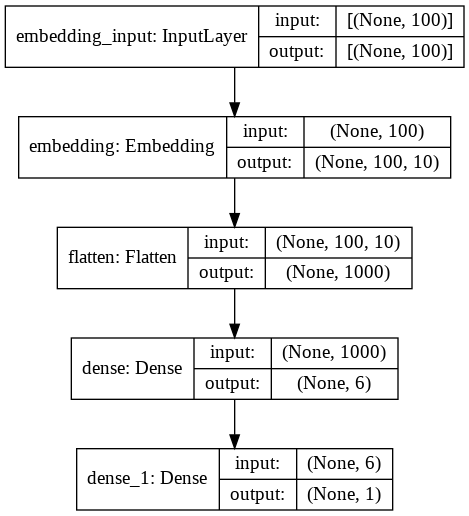

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True)

In [ ]:
#Logistic Regression
import numpy as np
clf = LogisticRegression(max_iter=500)
clf.fit(padded, np.array(train_y))
print ("Final Accuracy: %s"  % accuracy_score(np.array(test_y),clf.predict(testing_padded)))

Final Accuracy: 0.7699115044247787


In [ ]:
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(padded, np.array(train_y))
print ("Final Accuracy: %s"  % accuracy_score(np.array(test_y),clf.predict(testing_padded)))

Final Accuracy: 0.84375


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_y),clf.predict(testing_padded)))
print ("Final Accuracy: %s"  % accuracy_score(np.array(test_y),clf.predict(testing_padded)))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       116
           1       0.85      0.52      0.65        44

    accuracy                           0.84       160
   macro avg       0.85      0.74      0.77       160
weighted avg       0.84      0.84      0.83       160

Final Accuracy: 0.84375


In [ ]:
#SVM
svm = LinearSVC(C=0.05)
svm.fit(padded, np.array(train_y))
print ("Accuracy : %s" % ( accuracy_score(np.array(test_y),clf.predict(testing_padded))))
print("F1-Score: %f" % f1_score(np.array(test_y),clf.predict(testing_padded)))

Accuracy : 0.84375
F1-Score: 0.647887


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_y),clf.predict(testing_padded)))
print ("Accuracy : %s" % ( accuracy_score(np.array(test_y),clf.predict(testing_padded))))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       116
           1       0.85      0.52      0.65        44

    accuracy                           0.84       160
   macro avg       0.85      0.74      0.77       160
weighted avg       0.84      0.84      0.83       160

Accuracy : 0.84375


In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(padded, np.array(train_y))
print ("Final Accuracy: %s"  % accuracy_score(np.array(test_y),clf.predict(testing_padded)))

Final Accuracy: 0.80625


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_y),clf.predict(testing_padded)))
print ("Accuracy : %s" % ( accuracy_score(np.array(test_y),clf.predict(testing_padded))))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       116
           1       0.65      0.70      0.67        44

    accuracy                           0.81       160
   macro avg       0.76      0.78      0.77       160
weighted avg       0.82      0.81      0.81       160

Accuracy : 0.8125


In [ ]:
#urls count and @ in URLs
import re   
def Find(string): 
  
    # findall() has been used  
    # with valid conditions for urls in string 
    regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    url = re.findall(regex,string)       
    return [x[0] for x in url]

for i in range(len(test['Subject'])):
  string = test['Subject'][i]+test['Email Text'][i]
  li = Find(string)
  for k in li:
    if('@' in k):
      test['@ in URLs'][i] = True 
      break
  else:
    test['@ in URLs'][i] = False
  test['URLs'][i] = int(len(li))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16:

In [ ]:
#html content
import re 
for i in range(len(test['Subject'])):
  string = test['Subject'][i]+test['Email Text'][i]
  tag = "b"

  # regex to extract required strings 
  reg_str = "<" + tag + ">(.*?)</" + tag + ">"
  res = re.findall(reg_str, string) 

  if(len(res)>0):
    test['HTML content'][i] = True
  else:
    test['HTML content'][i] = False

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# phishy values
for i in range(len(test['Email Text'])):
  if(test['@ in URLs'][i] == False and test['Css'][i] == 0 and test['External Resources'][i] == 0 and test['Html iFrame'][i] == 0 and test['IPs in URLs'][i] == False and test['Javascript'][i] == 0):
    test['Phishy'][i] = False
  else:
    test['Phishy'][i] = True

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
test['Phishy'].value_counts()

False    2948
True      237
Name: Phishy, dtype: int64

In [ ]:
phish_data = pd.read_csv('/content/phishing3.csv')
good_data = pd.read_csv('/content/features.csv')

In [ ]:
# Concatenate
raw_data = pd.concat([phish_data,good_data],ignore_index=True)
raw_data.sample(10)

,Unnamed: 0,@ in URLs,Attachments,Css,Encoding,External Resources,Flash content,HTML content,Html Form,Html iFrame,IPs in URLs,Javascript,Phishy,URLs
2684,406,False,0,0,7bit,0,False,False,False,False,False,0,False,1
4451,2173,False,0,0,7bit,0,False,False,False,False,False,0,False,0
3682,1404,False,0,0,7bit,0,False,True,False,False,False,0,False,5
2531,253,False,0,0,quoted-printable,0,False,False,False,False,False,0,False,0
3037,759,False,0,0,7bit,0,False,False,False,False,False,0,False,0
122,122,False,0,0,7bit,0,False,True,False,False,True,0,True,16
2125,2125,False,0,0,quoted-printable,0,False,False,False,False,False,0,True,0
4051,1773,False,0,0,7bit,0,False,False,False,False,False,0,False,0
3882,1604,False,0,0,7bit,0,False,True,False,False,False,0,False,3
3650,1372,False,0,0,7bit,0,False,False,False,False,False,0,False,0


In [ ]:
# Rearrange columns - Put "Phishy" as last col
temp1 = raw_data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]]
temp2 = raw_data.iloc[:, 12]
raw_data = pd.concat([temp1, temp2],axis=1)

In [ ]:
# Transform strings in col 3 to ints
le = LabelEncoder()
le.fit(raw_data.iloc[:,3])
raw_data.iloc[:,3] = le.transform(raw_data.iloc[:,3])

In [ ]:
raw_data = raw_data.astype(int)

In [ ]:
trainX, testX, trainY, testY = train_test_split(raw_data.iloc[:, :12] , raw_data.iloc[:, 12], test_size=.4, random_state=0)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
trainX = sc.fit_transform(trainX)
testX = sc.fit_transform(testX)

In [ ]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(trainX, trainY)
predicted = cross_val_predict(classifier, trainX, trainY, cv = 10)
print(accuracy_score(trainY, predicted))

0.8647058823529412


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.array(test_y),clf.predict(testing_padded)))
print ("Accuracy : %s" % ( accuracy_score(np.array(test_y),clf.predict(testing_padded))))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       116
           1       0.65      0.70      0.67        44

    accuracy                           0.81       160
   macro avg       0.76      0.78      0.77       160
weighted avg       0.82      0.81      0.81       160

Accuracy : 0.8125


In [ ]:
#xg boost
from xgboost import XGBClassifier
clf = XGBClassifier()
clf.fit(trainX, trainY)
predicted = cross_val_predict(clf, trainX, trainY, cv = 10)
print(accuracy_score(trainY, predicted))

0.9301470588235294


In [ ]:
y_pred = clf.predict(testX)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY, y_pred)
print(cm)

[[819  67]
 [ 62 866]]


In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression, SGDClassifier
import numpy as np
clf = LogisticRegression(max_iter=500)
clf.fit(trainX, trainY)
predicted = cross_val_predict(clf, trainX, trainY, cv = 10)
print(accuracy_score(trainY, predicted))

0.8514705882352941


In [ ]:
y_pred = clf.predict(testX)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY, y_pred)
print(cm)

[[699 187]
 [ 87 841]]


In [ ]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(trainX, trainY)
predicted = cross_val_predict(clf, trainX, trainY, cv = 10)
print(accuracy_score(trainY, predicted))

0.9253676470588236


In [ ]:
y_pred = clf.predict(testX)
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY, y_pred)
print(cm)

[[821  65]
 [ 70 858]]


In [ ]:
# taking phishing emails

In [ ]:
for i in range(len(test['phishing'])):
  if(test['phishing'][i] == 'ham' and test['Phishy'][i] == False):
    test['Class_of_mail'][i] = 'safe'
  if(test['phishing'][i] == 'ham' and test['Phishy'][i] == True):
    test['Class_of_mail'][i] = 'moderate'
  if(test['phishing'][i] == 'spam' and test['Phishy'][i] == False):
    test['Class_of_mail'][i] = 'moderate'
  if(test['phishing'][i] == 'spam' and test['Phishy'][i] == True):
    test['Class_of_mail'][i] = 'harmful'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [ ]:
test.sample(5)

NameError: ignored

In [ ]:
list_intruders = []
for s in range(len(test['Class_of_mail'])):
  if(test['Class_of_mail'][s] == 'harmful'):
    list_intruders.append(test['From'][s])
print(len(set(list_intruders)))

34


In [ ]:
for i in set(list_intruders):print(i) 

csruthi215@gmail.com
mail-noreply@google.com
marketingnews@newsletter.brusselsairport.be
crm@triggered.oyorooms.com
aswanathpanchumarthi@gmail.com
no-reply@pledge.cvc.nic.in
contact@protonvpn.com
noreply-58905@myanatomy.in
sridhar.swaminathan@bennett.edu.in
no-reply@accounts.google.com
sales@gayathrisarees.com
noreply@smule.com
yalamanchili.harika999@gmail.com
support@wattpad.zendesk.com
support@myxtur.freshdesk.com
info@interviewbit.com
newsletter@womens-health-express.com
noreply@youtube.com
certificate@pantechsolutions.net
hackers@hackerrankmail.com
info@net.shiprocket.in
trueman@truecaller.com
info@naukri.com
26.mohit@gmail.com
info@salesforcedevs.com
madhushi.verma@bennett.edu.in
sales@pantechsolutions.net
newsletter@gmatclub.com
horoscope@horoscopefree.com
no-reply@alerts.swiggy.in
admin@prepinsta.com
no-reply@mail.instagram.com
notification+zj4zoyj2fj06@facebookmail.com
no-reply@wattpadmail.com


In [ ]:
test['Class_of_mail'].value_counts()

safe        2172
moderate     942
harmful       71
Name: Class_of_mail, dtype: int64